# Caffe LSTM Example on Sin(t) Waveform Prediction
- Network & Solver definition
- Mini-Batch Training & Testing
- Inifnite time sequence inference
- Iterative Finetuning

Example based on http://www.xiaoliangbai.com/2018/01/30/Caffe-LSTM-SinWaveform-Batch by Xiaoliang Bai.<br>


In [1]:
import numpy as np
import math
import os
import caffe
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# change this to use CPU/GPU acceleration
USE_GPU = 1

if USE_GPU:
    GPU_ID = 0
    caffe.set_mode_gpu()
    caffe.set_device(GPU_ID)
else:
    caffe.set_mode_cpu()

%load_ext autoreload
%autoreload 2

In [2]:
# Use the sample generator from Tensorflow Sin(t) online
def generate_sample(f = 1.0, t0 = None, batch_size = 1, predict = 50, samples = 100):
    """
    Generates data samples.

    :param f: The frequency to use for all time series or None to randomize.
    :param t0: The time offset to use for all time series or None to randomize.
    :param batch_size: The number of time series to generate.
    :param predict: The number of future samples to generate.
    :param samples: The number of past (and current) samples to generate.
    :return: Tuple that contains the past times and values as well as the future times and values. In all outputs,
             each row represents one time series of the batch.
    """
    Fs = 100.0

    T = np.empty((batch_size, samples))
    Y = np.empty((batch_size, samples))
    FT = np.empty((batch_size, predict))
    FY = np.empty((batch_size, predict))

    _t0 = t0
    for i in range(batch_size):
        t = np.arange(0, samples + predict) / Fs
        if _t0 is None:
            t0 = np.random.rand() * 2 * np.pi
        else:
            t0 = _t0 + i/float(batch_size)

        freq = f
        if freq is None:
            freq = np.random.rand() * 3.5 + 0.5

        y = np.sin(2 * np.pi * freq * (t + t0))

        T[i, :] = t[0:samples]
        Y[i, :] = y[0:samples]

        FT[i, :] = t[samples:samples + predict]
        FY[i, :] = y[samples:samples + predict]

    return T, Y, FT, FY

In [3]:
net_path = 'lstm_demo_network.train.prototxt'
inference_path = 'lstm_demo_network.deploy.prototxt'
solver_config_path = 'lstm_demo_solver.prototxt'
snapshot_prefix = 'lstm_demo_snapshot'
# Network Parameters
n_input = 1 # single input stream
n_steps = 100 # timesteps
n_hidden = 15 # hidden units in LSTM
n_outputs = 50 # predictions in future time
batch_size = 20 # batch of data
NO_INPUT_DATA = -2 # defined numeric value for network if no input data is available
# Training Parameters
n_train = 3000
n_display = 200
n_adamAlpha = 0.002

## Training Network definition

In [4]:
#define and save the network
from caffe import layers as L, params as P
def gen_network(n_steps,n_outputs,batch_size,n_input,n_hidden):
    n = caffe.NetSpec()
    # the network is trained on a time series of n_steps + n_outputs
    
    # we have input data for n_steps, which the network needs to keep tracing for n_output more steps
    # labels are given for n_output steps for loss calculation
    
    # a third input (clip) gives a mask for the first element in each time series.
    # this seems cumbersome but it allows training on series longer than the unrolled network size
    # as well as inference on infinite sequences
    
    # the data shape for caffe LSTM/RNN layers is always T x B x ... where T is the timestep and B are
    # independent data series (for example multiple batches)
    n.data, n.label, n.clip = L.Input( shape=[ dict(dim=[n_steps,batch_size,n_input]),
                                           dict(dim=[n_outputs,batch_size,n_input]),
                                           dict(dim=[n_steps+n_outputs,batch_size]) ],ntop=3)

    # the data layer size must match the size of the unrolled network, as such we concatenate with dummy-values
    # indicating that no more input data is available beyond n_steps
    n.dummy=L.DummyData( data_filler=dict(type="constant",value = NO_INPUT_DATA),
                        shape=[ dict(dim=[n_outputs,batch_size,n_input]) ] )
    n.fulldata=L.Concat(n.data, n.dummy, axis=0)
    # the lstm layer with n_hidden neurons
    n.lstm1 = L.LSTM(n.fulldata, n.clip,
                     recurrent_param = dict(num_output=n_hidden,
                                            weight_filler = dict(type='gaussian', std=0.05),
                                            bias_filler = dict(type='constant',value=0)))
    # usually followed by a fully connected output layer
    n.ip1 = L.InnerProduct(n.lstm1, num_output=1, bias_term=True, axis=2,
                           weight_filler=dict(type='gaussian',mean=0,std=0.1))
    
    # in this implementation, the loss is calculated over
    # the entire time series, not just the predicted future
    n.fulllabel=L.Concat(n.data,n.label, axis=0)
    n.loss = L.EuclideanLoss(n.ip1,n.fulllabel)
    
    ns=n.to_proto()
    with open(net_path, 'w') as f:
        f.write(str(ns))

gen_network(n_steps, n_outputs, batch_size, n_input, n_hidden)

## Solver definition

In [5]:
#standard Adam solver
def gen_solver():
    sd = caffe.proto.caffe_pb2.SolverParameter()
    sd.random_seed = 0xCAFFE
    sd.train_net = net_path
    sd.test_net.append(net_path)
    sd.test_interval = 500  #
    sd.test_iter.append(100)
    sd.max_iter = n_train
    sd.snapshot = n_train
    sd.display = n_display
    sd.snapshot_prefix = snapshot_prefix
    if USE_GPU:
        sd.solver_mode = caffe.proto.caffe_pb2.SolverParameter.GPU
    else:
        sd.solver_mode = caffe.proto.caffe_pb2.SolverParameter.CPU
    sd.type = 'Adam'
    sd.lr_policy = 'fixed'
    sd.base_lr = n_adamAlpha

    with open(solver_config_path, 'w') as f:
        f.write(str(sd))
gen_solver()

### load the solver and create train and test nets
solver = caffe.get_solver(solver_config_path)

## LSTM specific weight initialisation

In [6]:
def init_weights(solver):
    # Initialize forget gate bias to 1
    #
    # from include/caffe/layers/lstm_layer.hpp:
    #/***
    # * The specific architecture used in this implementation is as described in
    # * "Learning to Execute" [arXiv:1410.4615], reproduced below:
    # *     i_t := \sigmoid[ W_{hi} * h_{t-1} + W_{xi} * x_t + b_i ]
    # *     f_t := \sigmoid[ W_{hf} * h_{t-1} + W_{xf} * x_t + b_f ]
    # *     o_t := \sigmoid[ W_{ho} * h_{t-1} + W_{xo} * x_t + b_o ]
    # *     g_t :=    \tanh[ W_{hg} * h_{t-1} + W_{xg} * x_t + b_g ]
    # *     c_t := (f_t .* c_{t-1}) + (i_t .* g_t)
    # *     h_t := o_t .* \tanh[c_t]
    # * In the implementation, the i, f, o, and g computations are performed as a
    # * single inner product.
    # ***/
    #
    # Weights and Biases are stored as a blob of size 4 * n_hidden
    # in order i,f,o,g the caffe LSTM implementation
    # As such [ n_hidden : 2 * n_hidden ] addresses the forget gates
    #
    # This is a common trick to speed up LSTM training.
    # Unfortunately Caffe does not offer selective weight initialisation in the layer definition.
    solver.net.params['lstm1'][1].data[n_hidden : 2 * n_hidden] = 1

init_weights(solver)

## Training

step  0 , loss =  4.962592601776123
step  200 , loss =  1.8391894102096558 , avg loss =  2.6720563358068468
step  400 , loss =  1.41872239112854 , avg loss =  1.4572241774201393
step  600 , loss =  0.782352089881897 , avg loss =  0.9588996408879757
step  800 , loss =  0.7073419690132141 , avg loss =  0.527329773157835
step  1000 , loss =  0.9478970170021057 , avg loss =  0.3760554810613394
step  1200 , loss =  0.5093501210212708 , avg loss =  0.27984686352312566
step  1400 , loss =  0.25635382533073425 , avg loss =  0.23506358724087476
step  1600 , loss =  0.16187909245491028 , avg loss =  0.21153877124190332
step  1800 , loss =  0.11073026061058044 , avg loss =  0.18088199369609356
step  2000 , loss =  0.10870532691478729 , avg loss =  0.16985909044742584
step  2200 , loss =  0.11600791662931442 , avg loss =  0.1534666386246681
step  2400 , loss =  0.1641770750284195 , avg loss =  0.1587398579902947
step  2600 , loss =  0.15925206243991852 , avg loss =  0.13227142579853535
step  2800 

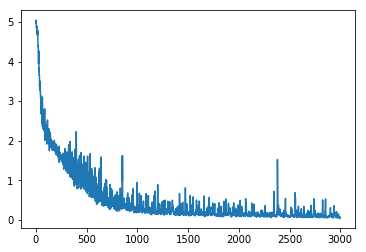

In [7]:
# Train network
def train_single(solver, niter, disp_step):
    train_loss = np.zeros(niter) # this is for plotting, later
    
    # the first entry in each time series has its clip mask set to 0
    clipmask = np.ones((n_steps+n_outputs,batch_size))
    clipmask[0,:] = np.zeros((batch_size))
    for i in range(niter):
        _, batch_x, _, batch_y = generate_sample(f=None,
                                         t0=None,
                                         batch_size=batch_size,
                                         samples=n_steps,
                                         predict=n_outputs)
        # IMPORTANT: Caffe LSTM has time in first dimension and batch in second, so
        # batched training data needs to be transposed
        batch_x = batch_x.transpose()
        batch_y = batch_y.transpose()
        solver.net.blobs['label'].data[:,:,0] = batch_y
        solver.net.blobs['data'].data[:,:,0]  = batch_x
        solver.net.blobs['clip'].data[:,:] = clipmask
        solver.step(1)
        train_loss[i] = solver.net.blobs['loss'].data
        if i % disp_step == 0:
            if i==0:
                print "step ", i, ", loss = ", train_loss[i]
            else:
                print "step ", i, ", loss = ", train_loss[i], ", avg loss = ", np.average(train_loss[i-disp_step:i])
    print("Finished training, iteration reached ", niter, " final loss = ", train_loss[niter-1],
        " final avg = ", np.average(train_loss[niter-disp_step:niter-1]))
    return train_loss

train_loss = train_single(solver,n_train,n_display)
#explicitly save snapshot if it has not been done yet
print 'saving snapshot to "%s_iter_%i.caffemodel"' % (snapshot_prefix,n_train)
solver.snapshot()
# plot loss value during training
plt.plot(np.arange(n_train), train_loss)
plt.show()

## Testing

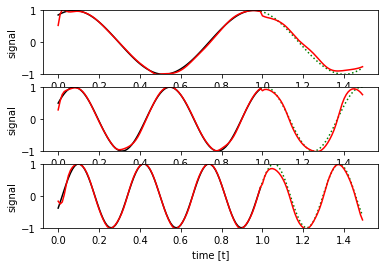

In [8]:
# Test the prediction with trained (unrolled) net
# we can change the batch size on the network at runtime, but not the number of timesteps (depth of unrolling)
def test_net(net,n_tests):
    batch_size = 1
    net.blobs['data'].reshape(n_steps, batch_size, n_input)
    net.blobs['label'].reshape(n_outputs, batch_size, n_input)
    net.blobs['clip'].reshape(n_steps+n_outputs, batch_size)
    net.blobs['dummy'].reshape(n_outputs, batch_size, n_input)
    net.reshape()

    clipmask = np.ones((n_steps+n_outputs,batch_size))
    clipmask[0,:] = np.zeros(batch_size)

    for i in range(1, n_tests + 1):
        plt.subplot(n_tests, 1, i)
        t, y, next_t, expected_y = generate_sample(f=i+0.1337, t0=None, samples=n_steps, predict=n_outputs)
        test_input = y.transpose()
        expected_y = expected_y.reshape(n_outputs)
        net.blobs['data'].data[:,:,0]  = test_input
        net.blobs['clip'].data[:,:] = clipmask
        net.forward()
        prediction = net.blobs['ip1'].data

        # remove the batch size dimensions
        t = t.squeeze()
        y = y.squeeze()
        next_t = next_t.squeeze()
        t2 = np.append(t,next_t)
        prediction = prediction.squeeze()
        
        plt.plot(t, y, color='black')
        plt.plot(np.append(t[-1], next_t), np.append(y[-1], expected_y), color='green', linestyle=":")
        plt.plot(t2, prediction, color='red')
        plt.ylim([-1, 1])
        plt.xlabel('time [t]')
        plt.ylabel('signal')
    plt.show()
test_net(solver.test_nets[0],3)

## Network definition for infinite length sequence inference:

In [9]:
#generate inference single time step network
def gen_deploy_network(n_input, n_hidden):
    n = caffe.NetSpec()
    # This network has only scalar input and output data 
    # No unrolling takes place, as such the length of each time series is 1
    # No batch processing either (batch size is 1)
    # The beginning of a new series (discarding LSTM hidden data) is indicated through the clip flag
    n.data, n.clip = L.Input( shape=[ dict(dim=[1,1,n_input]),
                                           dict(dim=[1,1]) ],ntop=2)
    n.lstm1 = L.LSTM(n.data, n.clip,
                     recurrent_param = dict(num_output=n_hidden,
                                            weight_filler = dict(type='uniform',min=-0.08,max=0.08)))
    n.ip1 = L.InnerProduct(n.lstm1, num_output=1, bias_term=True, axis=2,
                           weight_filler=dict(type='gaussian',mean=0,std=0.1))
    # n.ip1 is the output layer
    # there is no loss layer and no loss calculation
    # this network is extremely small and performant, compared to the unrolled training network
    ns=n.to_proto()
    return ns

ns = gen_deploy_network(n_input, n_hidden)
with open(inference_path, 'w') as f:
    f.write(str(ns))

# load Network with weights from previously trained network
# alternatively the network could be loaded without weights and then explicitly assigned (copied) layer by layer
print 'loading snapshot from "%s_iter_%i.caffemodel"' % (snapshot_prefix,n_train)
net = caffe.Net(inference_path,caffe.TEST,weights='%s_iter_%i.caffemodel'%(snapshot_prefix,n_train))

loading snapshot from "lstm_demo_snapshot_iter_3000.caffemodel"


## Inference / Validation

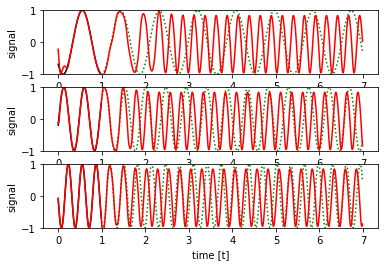

In [10]:
# the single step network can process infinite time series in a loop,
# as such we can increate n_outputs safely to have a glance at long term behaviour

def test_net_iterative(net,n_tests,n_outputs):
    for i in range(1, n_tests + 1):
        plt.subplot(n_tests, 1, i)
        t, y, next_t, expected_y = generate_sample(f=i+0.1337, t0=None, samples=n_steps, predict=n_outputs)
        expected_y = expected_y.reshape(n_outputs)

        net.blobs['clip'].data[0,0]=0
        prediction = []
        for T in range(n_steps):
            net.blobs['data'].data[0,0,0] = y[0,T]
            net.forward()
            prediction.append(net.blobs['ip1'].data[0,0,0])
            net.blobs['clip'].data[0,0]=1
        
        for T in range(n_outputs):
            # in this case we have to manually indicate to the network
            # that there is no more input data at the current time step
            net.blobs['data'].data[0,0,0] = NO_INPUT_DATA
            net.forward()
            prediction.append(net.blobs['ip1'].data[0,0,0])
            net.blobs['clip'].data[0,0]=1
        
        # remove the batch size dimensions
        t = t.squeeze()
        y = y.squeeze()
        next_t = next_t.squeeze()
        t2 = np.append(t,next_t)
        prediction = np.array(prediction)
        
        plt.plot(t, y, color='black')
        plt.plot(np.append(t[-1], next_t), np.append(y[-1], expected_y), color='green', linestyle=":")
        plt.plot(t2, prediction, color='red')
        plt.ylim([-1, 1])
        plt.xlabel('time [t]')
        plt.ylabel('signal')
    plt.show()

test_net_iterative(net,3,600)

### Observation:
The network drifts towards a generic sine wave when let running for longer than the training sample size.
What happens if we train with a longer training window?

step  0 , loss =  5.023901462554932
step  800 , loss =  2.930605888366699 , avg loss =  3.3501386097073556
step  1600 , loss =  3.2343006134033203 , avg loss =  3.1006170719861985
step  2400 , loss =  3.4342029094696045 , avg loss =  3.174943035244942
step  3200 , loss =  2.500319004058838 , avg loss =  3.0550656193494796
step  4000 , loss =  2.198803186416626 , avg loss =  2.5845771250128746
step  4800 , loss =  2.1764774322509766 , avg loss =  2.2972987045347693
step  5600 , loss =  1.3135526180267334 , avg loss =  1.9764886521548033
step  6400 , loss =  1.837260365486145 , avg loss =  1.5252129489183426
step  7200 , loss =  1.7262616157531738 , avg loss =  1.052608643360436
step  8000 , loss =  0.2858542501926422 , avg loss =  0.8007405941188336
step  8800 , loss =  0.7817566394805908 , avg loss =  0.6598656728491187
step  9600 , loss =  1.2146873474121094 , avg loss =  0.5954470820352435
step  10400 , loss =  0.4325614273548126 , avg loss =  0.5319335683993995
step  11200 , loss = 

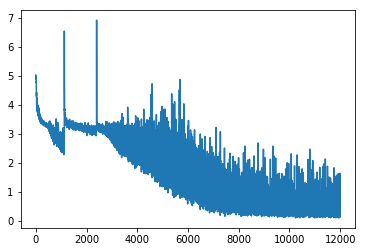

In [41]:
n_outputs = 200
n_train = 12000
net_path = 'lstm_demo2_network.train.prototxt'
solver_config_path = 'lstm_demo2_solver.prototxt'
snapshot_prefix = 'lstm_demo2_snapshot'

gen_network(n_steps, n_outputs, batch_size, n_input, n_hidden)
gen_solver()
solver = caffe.get_solver(solver_config_path)
init_weights(solver)
train_loss = train_single(solver,n_train,800)
plt.plot(np.arange(n_train), train_loss)
plt.show()

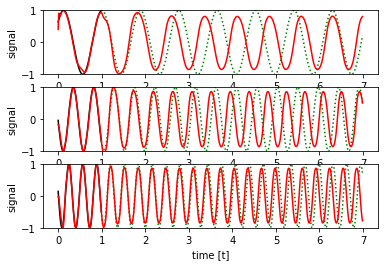

In [43]:
net.copy_from('%s_iter_%i.caffemodel'%(snapshot_prefix,n_train))
test_net_iterative(net,3,600)

### Observation:
With the longer unrolling window, the training converges much slower. The loss accumulated at the end of the window needs to backpropagate many steps until it reaches a timestep in which there is still a useful memory in the LSTM layer. At the same time, with this signal example, there is a strong gradient towards a local minima. Under euclidian loss, a zero line has always less error than a wrong signal, which encourages some amplitude decay.

This could possibly be avoided with a loss calculation that penalizes a weak signal, but this would require a custom loss layer.

Another option is attempting iterative fine tuning with slowly increasing time windows. As a bonus, this allows doing most of the training with shorter windows, which means smaller networks and faster computation.

## Iterative finetuning

initial training
step  0 , loss =  5.001683712005615
step  400 , loss =  1.272274374961853 , avg loss =  2.14021479845047
step  800 , loss =  0.3392722010612488 , avg loss =  0.7606009420752525
step  1200 , loss =  0.20268060266971588 , avg loss =  0.33767378274351356
step  1600 , loss =  0.16440801322460175 , avg loss =  0.19803098613396286
step  2000 , loss =  0.11226607114076614 , avg loss =  0.14224558904767037
step  2400 , loss =  0.08813808113336563 , avg loss =  0.12798880870454013
step  2800 , loss =  0.07497939467430115 , avg loss =  0.09942170452326536
step  3200 , loss =  0.24398040771484375 , avg loss =  0.09181898470968008
step  3600 , loss =  0.05118188261985779 , avg loss =  0.08637111162766814
('Finished training, iteration reached ', 4000, ' final loss = ', 0.03411295264959335, ' final avg = ', 0.07095204101394591)


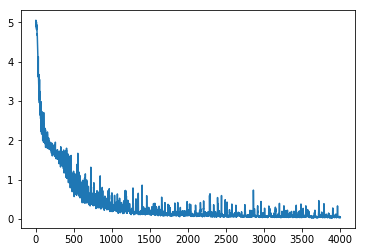

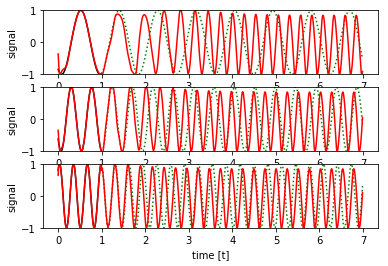

In [28]:
n_display = 400
n_outputs = 50
n_train = 4000
net_path = 'lstm_demo3_0_network.train.prototxt'
solver_config_path = 'lstm_demo3_0_solver.prototxt'
snapshot_prefix = 'lstm_demo3_0_snapshot'

print "initial training"
gen_network(n_steps, n_outputs, batch_size, n_input, n_hidden)
gen_solver()
solver = caffe.get_solver(solver_config_path)
init_weights(solver)
train_loss = train_single(solver,n_train,n_display)
plt.plot(np.arange(n_train), train_loss)
plt.show()
net_0 = '%s_iter_%i.caffemodel'%(snapshot_prefix,n_train)
net.copy_from(net_0)
test_net_iterative(net,3,600)


finetuning with doubled output length
step  0 , loss =  0.8099015951156616
step  400 , loss =  0.21753725409507751 , avg loss =  0.42320312580093744
step  800 , loss =  0.5601918697357178 , avg loss =  0.32237608317285776
step  1200 , loss =  0.1803084760904312 , avg loss =  0.27121006391942504
step  1600 , loss =  0.11833205074071884 , avg loss =  0.25394948601722717
step  2000 , loss =  0.23071134090423584 , avg loss =  0.21909179151058197
step  2400 , loss =  0.8012194633483887 , avg loss =  0.2140821596235037
step  2800 , loss =  0.1575007289648056 , avg loss =  0.21155558813363315
step  3200 , loss =  0.09627681970596313 , avg loss =  0.18416279467754065
step  3600 , loss =  0.2497120499610901 , avg loss =  0.16913008654490114
('Finished training, iteration reached ', 4000, ' final loss = ', 0.19583263993263245, ' final avg = ', 0.16355146197858908)


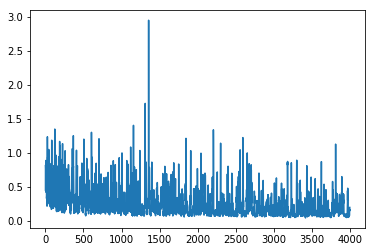

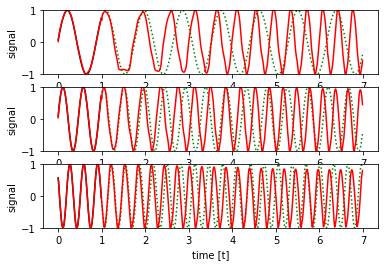

In [29]:
n_outputs = 100
net_path = 'lstm_demo3_1_network.train.prototxt'
solver_config_path = 'lstm_demo3_1_solver.prototxt'
snapshot_prefix = 'lstm_demo3_1_snapshot'

print "finetuning with doubled output length"
gen_network(n_steps, n_outputs, batch_size, n_input, n_hidden)
gen_solver()
solver = caffe.get_solver(solver_config_path)
solver.net.copy_from(net_0)
train_loss = train_single(solver,n_train,n_display)
plt.plot(np.arange(n_train), train_loss)
plt.show()
net_1 = '%s_iter_%i.caffemodel'%(snapshot_prefix,n_train)
net.copy_from(net_1)
test_net_iterative(net,3,600)

finetuning with 4 times output length
step  0 , loss =  3.3522541522979736
step  400 , loss =  2.3836734294891357 , avg loss =  1.1396523872762918
step  800 , loss =  0.5048739314079285 , avg loss =  0.9933038283139467
step  1200 , loss =  0.8721814751625061 , avg loss =  0.8151442534476518
step  1600 , loss =  1.3956053256988525 , avg loss =  0.7459086469188333
step  2000 , loss =  0.6706945896148682 , avg loss =  0.6900510047748685
step  2400 , loss =  0.6747839450836182 , avg loss =  0.6285985044389963
step  2800 , loss =  0.5432037115097046 , avg loss =  0.5996283163502812
step  3200 , loss =  0.43809133768081665 , avg loss =  0.5604662743583322
step  3600 , loss =  0.25176334381103516 , avg loss =  0.5525968099758028
step  4000 , loss =  0.27654793858528137 , avg loss =  0.528304709456861
step  4400 , loss =  0.2342434674501419 , avg loss =  0.5422565278969705
step  4800 , loss =  0.29954248666763306 , avg loss =  0.46564584456384184
step  5200 , loss =  0.2546829581260681 , avg l

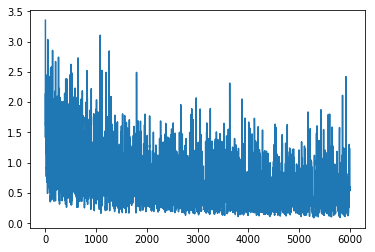

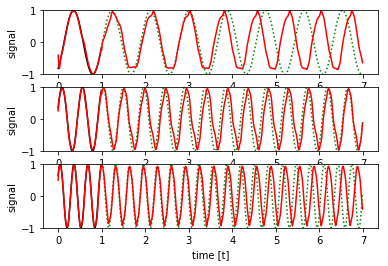

In [37]:
n_outputs = 200
n_train = 6000
net_path = 'lstm_demo3_2_network.train.prototxt'
solver_config_path = 'lstm_demo3_2_solver.prototxt'
snapshot_prefix = 'lstm_demo3_2_snapshot'

print "finetuning with 4 times output length"
gen_network(n_steps, n_outputs, batch_size, n_input, n_hidden)
gen_solver()
solver = caffe.get_solver(solver_config_path)
solver.net.copy_from(net_1)
train_loss = train_single(solver,n_train,n_display)
plt.plot(np.arange(n_train), train_loss)
plt.show()
net_2 = '%s_iter_%i.caffemodel'%(snapshot_prefix,n_train)
net.copy_from(net_2)
test_net_iterative(net,3,600)

finetuning with 8 times output length
step  0 , loss =  1.7953565120697021
step  400 , loss =  1.6358442306518555 , avg loss =  2.835002093911171
step  800 , loss =  2.731293201446533 , avg loss =  2.6876618030667303
step  1200 , loss =  2.716571807861328 , avg loss =  2.556609472036362
step  1600 , loss =  3.8206191062927246 , avg loss =  2.5261489440500737
step  2000 , loss =  2.0830764770507812 , avg loss =  2.4522755005955696
step  2400 , loss =  2.381643056869507 , avg loss =  2.3497636130452157
step  2800 , loss =  1.9426933526992798 , avg loss =  2.241594193428755
step  3200 , loss =  2.7272095680236816 , avg loss =  2.148105787038803
step  3600 , loss =  1.0517469644546509 , avg loss =  2.1067603731155398
step  4000 , loss =  1.531059741973877 , avg loss =  1.9903657440841198
step  4400 , loss =  0.7892651557922363 , avg loss =  1.9613118508458138
step  4800 , loss =  2.263145685195923 , avg loss =  1.8800240163505078
step  5200 , loss =  0.8800941705703735 , avg loss =  1.7895

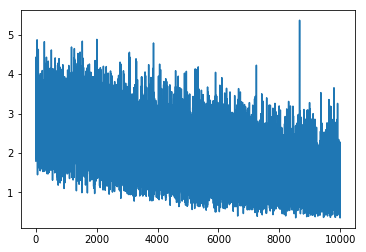

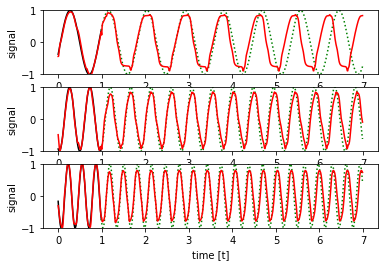

In [39]:
n_outputs = 400
n_train = 10000
net_path = 'lstm_demo3_3_network.train.prototxt'
solver_config_path = 'lstm_demo3_3_solver.prototxt'
snapshot_prefix = 'lstm_demo3_3_snapshot'

print "finetuning with 8 times output length"
gen_network(n_steps, n_outputs, batch_size, n_input, n_hidden)
gen_solver()
solver = caffe.get_solver(solver_config_path)
solver.net.copy_from(net_2)
train_loss = train_single(solver,n_train,n_display)
plt.plot(np.arange(n_train), train_loss)
plt.show()
net_3 = '%s_iter_%i.caffemodel'%(snapshot_prefix,n_train)
net.copy_from(net_3)
test_net_iterative(net,3,600)

### Long term test

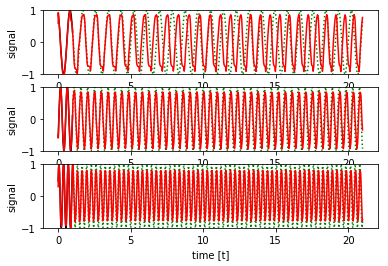

In [40]:
test_net_iterative(net,3,2000)